# Classification Stimulation-Imagination

## Apprentissage sur Foot; Test sur Hand

Region motrice seulement - Parcellation BASC 

22s - SVM Linéaire


In [75]:
import numpy as np

from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from nilearn.datasets import load_mni152_brain_mask
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score

%matplotlib inline
import sys
sys.path[0]='Z:/GitHub/gsp-learn/'
from gsplearn.GSPPlot import plot_selectedregions

In [76]:
# Import data
names='ap','as','bh','bi','cmp','cas','cs','cb','gm','gn','gbn','mv','ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs'
smt='ss'
fold_g = 'F:/IRM_Marche/'
label_i=np.loadtxt(fold_g+'label_main.txt','S12')
blocks_i=np.loadtxt(fold_g+'block_main.txt','int')

roi=np.zeros([0,444])
rest=np.zeros([0,444])
label=np.zeros([0,3])
blocks=np.array([])
for n in names:
    sim_filename=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'
    rest_filename=  fold_g+'mni4060/asymroirest_'+smt+'_'+n+'.npz'  
    tmproi=np.load(sim_filename)['roi']
    tmprest=np.load(rest_filename)['roi']
    roi=np.concatenate((roi,tmproi))
    rest=np.concatenate((rest,tmprest))
    label=np.append(label,label_i,axis=0)
    blocks=np.append(blocks,blocks_i) 
    
# Remove first volumes per block    
index=[]
for x in range(label.shape[0]):
    if label[x,0]!=label[x-1,0]:
        index.append(x)
    elif label[x,0]!=label[x-2,0]:
        index.append(x)
        
label=np.delete(label,index,0)
blocks=np.delete(blocks,index,0)
roi=np.delete(roi,index,0)

condition_cat = np.logical_or(label[:,1] == b'foot', label[:,1] == b'hand')
condition_out=np.logical_not(label[:,2]== b'des')
condition_mask= condition_cat==condition_out
block=blocks[condition_mask]
y=label[condition_mask]
cond=roi[condition_mask]
   
train_mask= y[:,1]==b'foot'
test_mask= y[:,1]==b'hand'
y_train=y[train_mask,0]
y_test=y[test_mask,0]
roi_train=cond[train_mask]#   
roi_test=cond[test_mask]
block=block[train_mask]

## Data indiv

index_i=[]
nb_s=len(names)
for x in range(label_i.shape[0]):
    if label_i[x,0]!=label_i[x-1,0]:
        index_i.append(x)
    elif label_i[x,0]!=label_i[x-2,0]:
        index_i.append(x)
        
label_i=np.delete(label_i,index_i,0)
blocks_i=np.delete(blocks_i,index_i,0)

condition_cat_i = np.logical_or(label_i[:,1] == b'foot', label_i[:,1] == b'hand')
condition_out_i=np.logical_not(label_i[:,2]== b'des')
condition_mask_i= condition_cat_i==condition_out_i
block_i=blocks_i[condition_mask_i]
y_i=label_i[condition_mask_i]

   
train_mask_i= y_i[:,1]==b'foot'
test_mask_i= y_i[:,1]==b'hand'
y_train_i=y_i[train_mask_i,0]
y_test_i=y_i[test_mask_i,0]
  
block_i=block_i[test_mask_i]

In [77]:
# Classification
scaler = preprocessing.StandardScaler()
svm= SVC(C=1., kernel="linear")  
k=50 #best 52
feature_selection = SelectKBest(f_classif, k=k)
    
from sklearn.ensemble import ExtraTreesClassifier
#svm = ExtraTreesClassifier(n_estimators=1000,
#                              max_features=5,
#                              random_state=0,
#                           class_weight ='balanced')
from sklearn.linear_model import LogisticRegression
#svm=LogisticRegression(penalty='l1')
pipeline = Pipeline([('scale', scaler),('classif_name', svm)])

In [78]:
# Prepare ploting
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')['scale444']
brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory_level=1, verbose=0,
                           detrend=True, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels'
                           )
masker.fit()

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


NiftiLabelsMasker(background_label=0, detrend=True, high_pass=0.01,
         labels_img='C:\\Users\\mmenoret/nilearn_data\\basc_multiscale_2015\\template_cambridge_basc_multiscale_nii_asym\\template_cambridge_basc_multiscale_asym_scale444.nii.gz',
         low_pass=None,
         mask_img=<nibabel.nifti1.Nifti1Image object at 0x000000002A5FCF28>,
         memory=Memory(cachedir=None), memory_level=1,
         resampling_target='labels', sessions=None, smoothing_fwhm=None,
         standardize=False, t_r=2.28, verbose=0)

### Classification seulement sur regions BASC motrices

In [79]:
motor_region_index=np.fromfile('F:/IRM_Marche/masquesROI/reg_motorC_basc444asym.np','int')
#motor_region_index=np.fromfile('F:/IRM_Marche/harv_motorlarge_basc444asym.np',dtype=int)
#motor_region_index=np.fromfile('F:/IRM_Marche/masquesROI/reg_all_nooccipital_basc444asym.np','int')
print(motor_region_index)

[  1  10  11  16  20  23  27  28  29  30  35  38  44  46  47  49  50  52
  53  54  57  58  65  67  68  69  70  75  77  78  80  83  84  86  88  89
  91  92  95  99 101 104 107 108 110 111 113 120 121 122 124 126 131 133
 134 135 136 137 138 139 142 144 147 148 149 150 152 154 155 156 160 161
 163 164 167 168 176 178 179 182 184 186 189 191 192 195 199 200 201 202
 206 208 209 211 212 213 214 216 217 218 219 228 230 233 237 239 244 247
 249 252 254 257 260 264 266 267 268 270 272 273 275 277 278 279 280 281
 282 283 284 287 291 293 294 296 299 301 302 303 306 308 310 311 312 316
 320 324 325 326 330 331 336 343 344 351 358 363 364 365 369 371 372 374
 378 380 381 387 392 394 397 398 400 401 403 409 413 414 418 421 424 425
 428 432 435 437 439 441 443]


In [80]:
result_i=np.zeros(nb_s)
pipeline = Pipeline([('scale', scaler),('classif_name', svm)])
for ni,n in enumerate(names):
    sim_filename=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'
    roi_i=np.load(sim_filename)['roi']
    roi_i=np.delete(roi_i,index_i,0)
    roi_m=roi_i[:,motor_region_index-1]
    cond_i=roi_m[condition_mask_i]
    roi_test_i=cond_i[test_mask_i]
    roi_train_i=cond_i[train_mask_i]# 
    pipeline.fit(roi_train_i, y_train_i)
    prediction = pipeline.predict(roi_test_i) 
    result_i[ni]=accuracy_score(prediction,y_test_i)
    print(n,'Accuracy:',result_i[ni]*100,'%')
print(result_i.mean())

ap Accuracy: 56.1403508772 %
as Accuracy: 52.6315789474 %
bh Accuracy: 52.6315789474 %
bi Accuracy: 64.0350877193 %
cmp Accuracy: 73.6842105263 %
cas Accuracy: 44.7368421053 %
cs Accuracy: 57.0175438596 %
cb Accuracy: 59.649122807 %
gm Accuracy: 49.1228070175 %
gn Accuracy: 46.4912280702 %
gbn Accuracy: 71.9298245614 %
mv Accuracy: 43.8596491228 %
ms Accuracy: 50.8771929825 %
pm Accuracy: 57.0175438596 %
pc Accuracy: 77.1929824561 %
ph Accuracy: 61.4035087719 %
pa Accuracy: 70.1754385965 %
pv Accuracy: 46.4912280702 %
pom Accuracy: 82.4561403509 %
rdc Accuracy: 41.2280701754 %
ti Accuracy: 65.7894736842 %
vs Accuracy: 57.0175438596 %
0.582535885167


In [81]:
for ni,n in enumerate(names):
    sim_filename=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'
    roi_i=np.load(sim_filename)['roi']
    roi_i=np.delete(roi_i,index_i,0)
    roi_m=roi_i[:,motor_region_index-1]
    cond_i=roi_m[condition_mask_i]
    roi_test_i=cond_i[test_mask_i]
    roi_train_i=cond_i[train_mask_i]# 
    pipeline.fit(roi_test_i, y_test_i)
    prediction = pipeline.predict(roi_train_i) 
    result_i[ni]=accuracy_score(prediction,y_train_i)
    print(n,'Accuracy:',result_i[ni]*100,'%')
print(result_i.mean())

ap Accuracy: 57.0175438596 %
as Accuracy: 53.5087719298 %
bh Accuracy: 55.2631578947 %
bi Accuracy: 59.649122807 %
cmp Accuracy: 53.5087719298 %
cas Accuracy: 51.7543859649 %
cs Accuracy: 53.5087719298 %
cb Accuracy: 57.0175438596 %
gm Accuracy: 50.0 %
gn Accuracy: 52.6315789474 %
gbn Accuracy: 57.8947368421 %
mv Accuracy: 50.0 %
ms Accuracy: 50.8771929825 %
pm Accuracy: 53.5087719298 %
pc Accuracy: 65.7894736842 %
ph Accuracy: 55.2631578947 %
pa Accuracy: 60.5263157895 %
pv Accuracy: 51.7543859649 %
pom Accuracy: 71.0526315789 %
rdc Accuracy: 42.1052631579 %
ti Accuracy: 51.7543859649 %
vs Accuracy: 71.0526315789 %
0.55701754386


In [82]:
np.unique(y_test)

array([b'imag', b'stim'], 
      dtype='|S32')

In [83]:
roi_m_test=roi_test[:,motor_region_index-1]
roi_m_train=roi_train[:,motor_region_index-1]
pipeline.fit(roi_m_test, y_test)
prediction = pipeline.predict(roi_m_train)  
coef_h = pipeline.named_steps['classif_name'].coef_#feature_importances_
print('Accuracy Train:HAND Test: FOOT:',accuracy_score(prediction,y_train)*100,'%')

pipeline.fit(roi_m_train, y_train)
prediction = pipeline.predict(roi_m_test)  
coef_f = pipeline.named_steps['classif_name'].coef_#feature_importances_
print('Accuracy Train:FOOT Test:HAND',accuracy_score(prediction,y_test)*100,'%')

Accuracy Train:HAND Test: FOOT: 60.8054226475 %
Accuracy Train:FOOT Test:HAND 59.5295055821 %


    - Train Hand Test Foot non significatif d'après permutation (0.27) --> voir plus bas
    - Train Foot Test Hand non significatif d'après permutation (0.1) --> voir plus bas

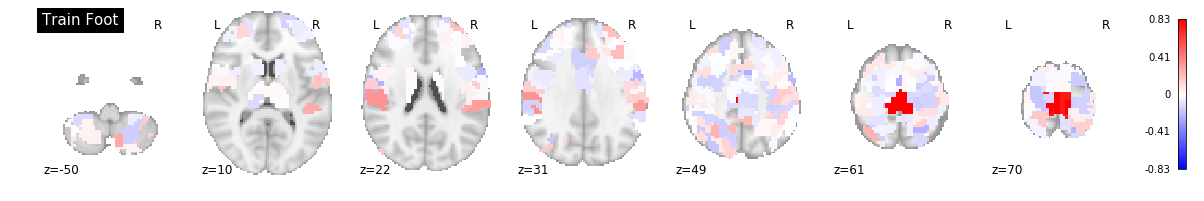

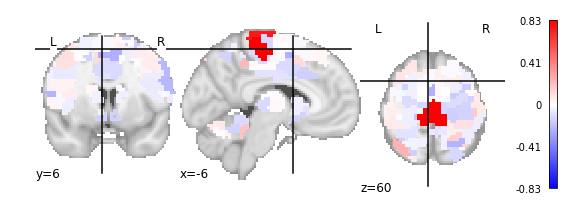

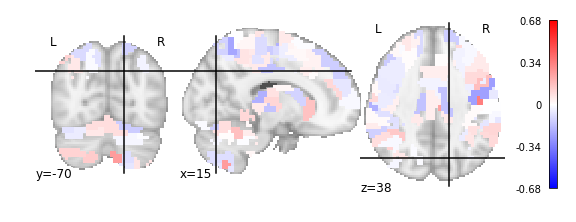

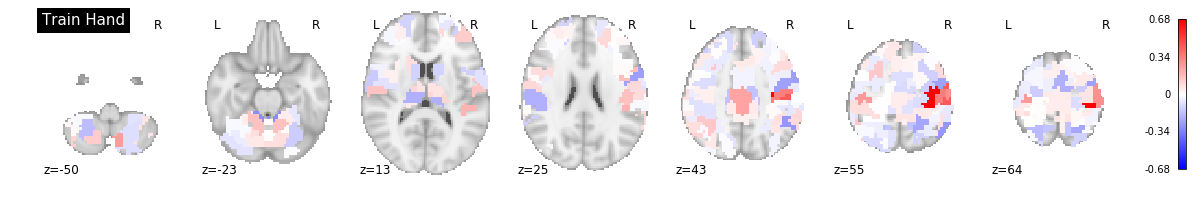

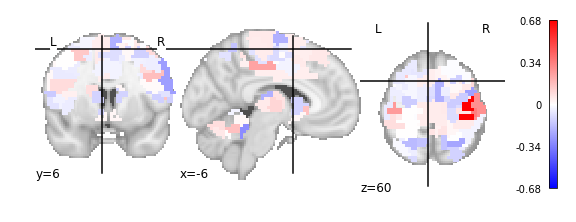

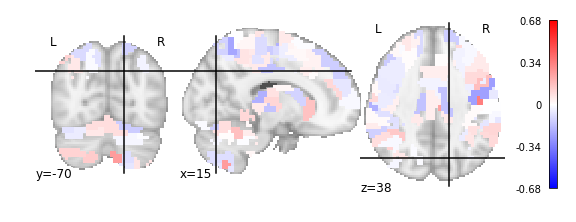

In [84]:
# Plot resulting weights of the SVM & selected regions

#coef = pipeline_anova.named_steps['anova'].inverse_transform(coef)
coef_tr_f=np.zeros([1,444])
coef_tr_h=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    coef_tr_f[0,n-1]=coef_f[0,i]
    coef_tr_h[0,n-1]=coef_h[0,i]
from nilearn.plotting import plot_stat_map
weight_img_trf = masker.inverse_transform(coef_tr_f)
weight_img_trh = masker.inverse_transform(coef_tr_h)
plot_stat_map(weight_img_trf, title='Train Foot',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trf,cmap='bwr', cut_coords=[-6, 6, 60])
plot_stat_map(weight_img_trh,cmap='bwr', cut_coords=[15, -70, 38])

plot_stat_map(weight_img_trh, title='Train Hand',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trh,cmap='bwr', cut_coords=[-6, 6, 60])
plot_stat_map(weight_img_trh,cmap='bwr', cut_coords=[15, -70, 38])

In [85]:
cv = LeaveOneLabelOut(block)
score_cv = cross_val_score(pipeline, roi_m_train, y_train,cv=cv)
print('FOOT only CV',score_cv.mean())
score_cv = cross_val_score(pipeline, roi_m_test, y_train,cv=cv)
print('HAND only CV',score_cv.mean())

FOOT only CV 0.763047138047
HAND only CV 0.779100529101


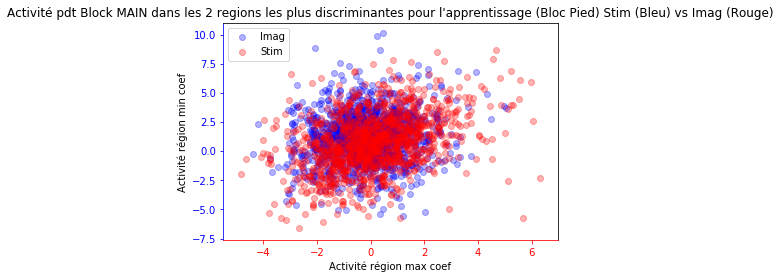

In [86]:
import matplotlib.pyplot as plt
amax_S=roi_m_test[y_train==b'stim',coef_f.argmax()]
amax_I=roi_m_test[y_train==b'imag',coef_f.argmax()]
amin_S=roi_m_test[y_train==b'stim',coef_f.argmin()]
amin_I=roi_m_test[y_train==b'imag',coef_f.argmin()]
fig=plt.figure()
ax=plt.subplot(1,1,1)
ax.scatter(amax_I,amin_I,c='b',alpha=0.3,label='Imag')
ax.scatter(amax_S,amin_S,c='r',alpha=0.3,label='Stim')

plt.xlabel('Activité région max coef')
plt.ylabel('Activité région min coef')
ax.spines['bottom'].set_color('r')
ax.spines['left'].set_color('b')
ax.tick_params(axis='x', colors='r')
ax.tick_params(axis='y', colors='b')
plt.legend()
#plt.xlim(-10,10)
#plt.ylim(-15,15)
plt.title("Activité pdt Block MAIN dans les 2 regions les plus discriminantes pour l'apprentissage (Bloc Pied) Stim (Bleu) vs Imag (Rouge)")

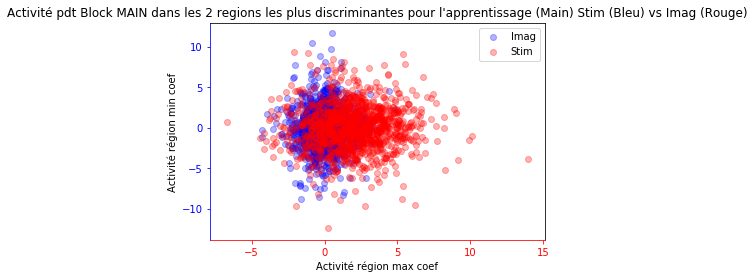

In [87]:
import matplotlib.pyplot as plt
amax_S=roi_m_test[y_train==b'stim',coef_h.argmax()]
amax_I=roi_m_test[y_train==b'imag',coef_h.argmax()]
amin_S=roi_m_test[y_train==b'stim',coef_h.argmin()]
amin_I=roi_m_test[y_train==b'imag',coef_h.argmin()]
fig=plt.figure()
ax=plt.subplot(1,1,1)
ax.scatter(amax_I,amin_I,c='b',alpha=0.3,label='Imag')
ax.scatter(amax_S,amin_S,c='r',alpha=0.3,label='Stim')

plt.xlabel('Activité région max coef')
plt.ylabel('Activité région min coef')
ax.spines['bottom'].set_color('r')
ax.spines['left'].set_color('b')
ax.tick_params(axis='x', colors='r')
ax.tick_params(axis='y', colors='b')
plt.legend()
#plt.xlim(-10,10)
#plt.ylim(-15,15)
plt.title("Activité pdt Block MAIN dans les 2 regions les plus discriminantes pour l'apprentissage (Main) Stim (Bleu) vs Imag (Rouge)")

(array([   5.,   14.,   74.,  260.,  426.,  306.,  120.,   41.,    6.,    2.]),
 array([-4.27071273, -3.36009703, -2.44948133, -1.53886563, -0.62824993,
         0.28236577,  1.19298147,  2.10359717,  3.01421287,  3.92482857,
         4.83544427]),
 <a list of 10 Patch objects>)

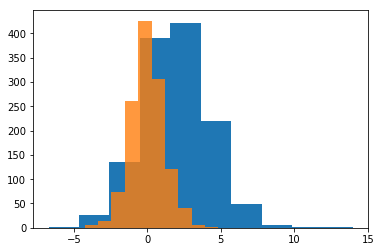

In [88]:
plt.hist(amax_S)
plt.hist(amax_I,alpha=0.8)

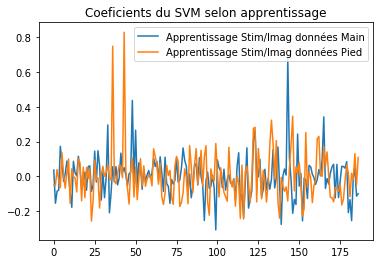

In [ ]:
import matplotlib.pyplot as plt
plt.plot(coef_h.T,label='Apprentissage Stim/Imag données Main')
plt.plot(coef_f.T,label='Apprentissage Stim/Imag données Pied')
plt.title('Coeficients du SVM selon apprentissage')
plt.legend()

### Test du niveau de chance (en gardant la structure de bloc)

In [95]:
### Permutation block
pipeline.fit(roi_m_train, y_train)
prediction = pipeline.predict(roi_m_test)  
result_tr_stim=accuracy_score(prediction,y_test)

pipeline.fit(roi_m_test, y_test)
prediction = pipeline.predict(roi_m_train)  
result_tr_imag=accuracy_score(prediction,y_train)

nb_p=1000
null_result_tr_stim=np.zeros(nb_p)
null_result_tr_imag=np.zeros(nb_p)
nb_s=len(names)
ncond=['stim','imag']
for i in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    # shuffle block number
    for suj in range(nb_s):
        xncond=np.random.permutation(ncond)
        suj_train_random=np.append(np.full(57,xncond[0],dtype='S12'),np.full(57,xncond[1],dtype='S12'))
        y_train_random=np.append(y_train_random,suj_train_random)

        
    pipeline.fit(roi_m_train, y_train_random)
    prediction = pipeline.predict(roi_m_test) 
    null_result_tr_stim[i]=accuracy_score(prediction,y_test)
    
    pipeline.fit(roi_m_test, y_train_random)
    prediction = pipeline.predict(roi_m_train) 
    null_result_tr_imag[i]=accuracy_score(prediction,y_train)

sign_tr_stim=(null_result_tr_stim>=result_tr_stim).sum()/nb_p
sign_tr_imag=(null_result_tr_imag>=result_tr_imag).sum()/nb_p
print('Train Foot',sign_tr_stim,'Train Hand',sign_tr_imag,)

Train Foot 0.095 Train Hand 0.014


20
15


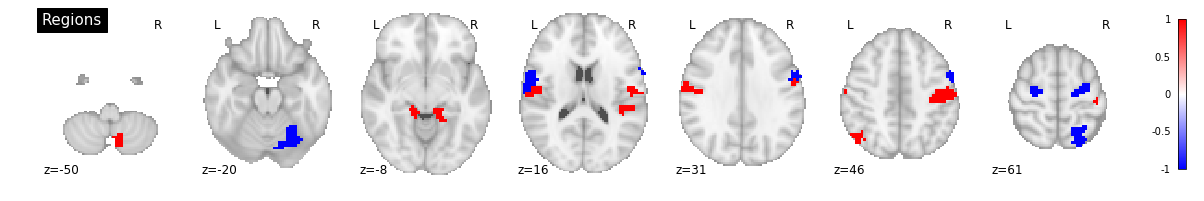

In [94]:
val=0.1
above=np.logical_and(abs(coef_h)>val, np.abs(coef_f)>val)
print(above.sum())
diff=np.sign(coef_h)==np.sign(coef_f)
index=np.logical_and(above,diff)
print(index.sum())

roi_index=np.zeros(coef_h.shape)
for i in range(coef_h.shape[1]):
    if index.T[i]:
        if np.sign(coef_h.T[i])==1:
            roi_index.T[i]=1
        else:
            roi_index.T[i]=-1
              

roi=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    roi[0,n-1]=roi_index[0,i]
weight = masker.inverse_transform(roi)
plot_stat_map(weight, title='Regions',display_mode='z',cmap='bwr')